In [23]:
import os
import sys
from collections import deque
from string import punctuation

In [24]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [25]:
class BSBI_indexing:
    def __init__(self, input_dir, block_size, output_dir):
        self.input_dir = input_dir
        self.block_size = block_size
        self.output_dir = output_dir
        self.number_of_documents = 0
        self.docId_to_doc_map = {}
        self.current_block = 0
        self.total_documents_size = 0
        self.current_docId = 0
        self.current_file = 0
        self.punctuation = punctuation
        self.term_to_docIds_map = {}
        self.term_to_docIds_sorted = []
        self.docId_to_terms = None
        self.current_termId = 0
        self.current_block_size = 0
        self.end_of_files = False
        self.porter = PorterStemmer()
        self.number_of_merges = 0

    def making_index(self):
        self.total_documents_size = 0

        print("constructing doc-docID map, please wait")
        # Construct a doc to docId mapping and find total doc size
        doc_index = 0
        for dir_path, dir_names, file_names in os.walk(self.input_dir):
            file_names.sort()
            for file_name in file_names:
                self.docId_to_doc_map[doc_index] = file_name
                file_path = os.path.join(dir_path, file_name)

                # making sure file path points to file, not a link
                if not os.path.islink(file_path):
                    file_size = os.path.getsize(file_path)

                    # if file exceeds the block size limit
                    if file_size >= self.block_size:
                        print("Program failed! {} size exceeds block size limit.".format(
                            self.docId_to_doc_map[doc_index]
                        ))
                        print("file size {} Kb > block size {} Kb".format(
                            file_size / 1024,
                            self.block_size / 1024
                        ))
                        sys.exit(1)
                    self.total_documents_size += file_size
                doc_index += 1

        self.number_of_documents = len(self.docId_to_doc_map)

        # ready output directory
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
        else:
            if os.path.isdir(self.output_dir):
                for dir_path, dir_names, file_names in os.walk(self.output_dir):
                    for file_name in file_names:
                        os.remove(os.path.join(dir_path, file_name))
            else:
                os.remove(self.output_dir)
                os.mkdir(self.output_dir)

        # Make Index
        while True:
            if self.current_docId < self.number_of_documents:
                print("Processing Document #{}, please wait. File: {}, Current Block {}"
                      .format(self.current_docId, self.docId_to_doc_map[self.current_docId], self.current_block))
            self.parse_next_document()
            self.invert_document()

            size = sys.getsizeof(self.term_to_docIds_map)
            current_block_size = self.current_block_size + size
            if current_block_size >= self.block_size or self.end_of_files:
                # now it's time to sort term-doc by terms and write it to the disk
                terms = list(self.term_to_docIds_map.keys())
                terms.sort()
                self.term_to_docIds_sorted = []
                for term in terms:
                    self.term_to_docIds_sorted.append((term, self.term_to_docIds_map[term]))
                    del self.term_to_docIds_map[term]
                self.term_to_docIds_map = sorted(self.term_to_docIds_map.items())
                self.write_block()
                self.current_block += 1
                self.term_to_docIds_map = {}
                self.current_block_size = 0
                if self.end_of_files:
                    break

        print("merging state initiated, Please wait")
        self.merge_blocks()
        print("All done!")

    def parse_next_document(self):
        self.docId_to_terms = None

        # receive next doc and it's size
        if self.current_docId > self.number_of_documents - 1:
            self.end_of_files = True
            return
        current_document_path = os.path.join(self.input_dir, self.docId_to_doc_map[self.current_docId])
        self.current_file = open(current_document_path, 'rt', encoding='utf-8')
        current_file_size = os.path.getsize(current_document_path)

        # parse document & make docId to terms List
        if current_file_size <= self.block_size:
            self.docId_to_terms = [self.current_docId, self.current_file.read()]
            self.current_file.close()
            self.current_docId += 1
        else:
            # overflowed the block
            print("Error! {} size exceeds block size limit.".format(
                self.docId_to_doc_map[self.current_docId]
            ))
            print("file size vs block size: {} Kb > {} Kb".format(
                current_file_size / 1024,
                self.block_size / 1024
            ))
            self.end_of_files = True

        # extract tokens form a doc and process them into terms
        self.docId_to_terms[1] = word_tokenize(self.docId_to_terms[1])
        self.preprocess_terms(self.docId_to_terms[1])

    def preprocess_terms(self, terms):
        size_of_terms = len(terms)
        for i in range(0, size_of_terms):
            # Removing Punctuation
            terms[i] = "".join([char for char in terms[i] if char not in punctuation])
            # Lowering all terms
            terms[i] = terms[i].lower()
            # stemming terms
            terms[i] = self.porter.stem(terms[i])

    def invert_document(self):
        if self.end_of_files:
            return
        # store terms as term-document postings
        index = 0
        number_of_new_terms = 0
        document_id = self.docId_to_terms[0]
        terms = self.docId_to_terms[1]
        while index < len(terms):
            term = terms[index]
            if term not in self.term_to_docIds_map:
                number_of_new_terms += 1
                size = sys.getsizeof(term)
                inc = size % 8
                if inc != 0:
                    size += 8 - inc
                self.term_to_docIds_map[term] = []
                self.current_block_size += size
            self.term_to_docIds_map[term].append(document_id)
            index += 1

        size = sys.getsizeof(document_id)
        self.current_block_size += size
        self.current_block_size += number_of_new_terms * 56
        self.current_block_size += number_of_new_terms * size
        self.current_block_size += 8 * index

        del self.docId_to_terms, terms

    def write_block(self):
        with open("{}/block{}.txt".format(self.output_dir, self.current_block), 'wt', encoding='utf-8') as file:
            for term, documents in self.term_to_docIds_sorted:
                for docId in documents:
                    file.write('{} {}\n'.format(term, docId))
        del self.term_to_docIds_map, file

    def merge_blocks(self):
        block_queue = deque()
        block_id = 0
        for dirpath, dirnames, filenames in os.walk(self.output_dir):
            for file in filenames:
                file_path = os.path.join(dirpath, file)
                block_queue.append(file_path)

        del filenames, file, dirpath

        while len(block_queue) > 1:
            file_path_a = block_queue.popleft()
            file_path_b = block_queue.popleft()
            print("merge round #{}".format(self.number_of_merges + 1))
            self.number_of_merges += 1

            merged_path = os.path.join(self.output_dir, 'merged{}.txt'.format(block_id))
            file_a = open(file_path_a, 'rt', encoding='utf-8')
            file_b = open(file_path_b, 'rt', encoding='utf-8')
            term_to_doc_a = file_a.readline()
            term_to_doc_b = file_b.readline()
            if term_to_doc_a == '' or term_to_doc_b == '':
                # file is empty
                file_a.close()
                file_b.close()
                if term_to_doc_a == '' and term_to_doc_b == '':
                    block_id += 2
                    continue
                elif term_to_doc_a == '':
                    os.rename(file_path_b, merged_path)
                elif term_to_doc_b == '':
                    os.rename(file_path_a, merged_path)
                block_queue.append(merged_path)
                block_id += 1
                continue
            merged_file = open(merged_path, 'wt', encoding='utf-8')
            term_doc_a = term_to_doc_a[:-1].split(' ')
            term_doc_b = term_to_doc_b[:-1].split(' ')

            # read line by line from files a , b and  writing on merge file until one of them  reaches end of file
            while True:
                if term_doc_a[0] < term_doc_b[0] or (
                        term_doc_a[0] == term_doc_b[0] and int(term_doc_a[1]) < int(term_doc_b[1])):
                    min_term_doc = term_doc_a
                    file_pointer = file_a
                else:
                    min_term_doc = term_doc_b
                    file_pointer = file_b
                merged_file.write(min_term_doc[0] + ' ' + min_term_doc[1] + '\n')

                if file_pointer == file_a:  # if min was from a
                    term_doc_a = file_a.readline()
                    if term_doc_a == '':
                        break  # file ended
                    term_doc_a = term_doc_a[:-1].split(' ')
                else:  # if min was from b
                    term_doc_b = file_b.readline()
                    if term_doc_b == '':
                        break  # file ended
                    term_doc_b = term_doc_b[:-1].split(' ')

                # check if a is reached the end write b till the end of it in merge file vise versa
            if term_doc_a == '':
                file_pointer = file_b
                file_a.close()
            else:
                file_pointer = file_a
                file_b.close()
            min_term_doc = file_pointer.readline()
            while min_term_doc != '':
                # write till end of selected file
                min_term_doc = min_term_doc[:-1].split(' ')
                merged_file.write(min_term_doc[0] + ' ' + min_term_doc[1] + '\n')
                min_term_doc = file_pointer.readline()
            file_pointer.close()
            merged_file.close()
            block_queue.append(merged_path)
            block_id += 1

        # convert one last merged file doc_ids into doc file name
        merged_file = open(block_queue.pop(), 'rt', encoding='utf-8')
        output_file = open(os.path.join(self.output_dir, 'output.txt'), 'wt', encoding='utf-8')
        term_doc = merged_file.readline()
        while term_doc != '':
            term_doc = term_doc[:-1].split(' ')
            output_file.write(term_doc[0] + ' ' + self.docId_to_doc_map[int(term_doc[1])] + '\n')
            term_doc = merged_file.readline()
        merged_file.close()
        output_file.close()

    def clear_output_directory(self):
        for dirpath, dirnames, filenames in os.walk(self.output_dir):
            for file in filenames:
                if not file == 'output.txt':
                    os.remove(os.path.join(dirpath, file))

In [59]:
input_directory = '/content/drive/MyDrive/CSE 419/Lab Assign-4/1000_documents'
output_directory = '/content/drive/MyDrive/CSE 419/Lab Assign-4/output_dir'

# initialize block size with 1MB
initial_block_size = 1 * 1024000

In [60]:
def calculate_total_file_size_in_bytes(input_directory):
    total_size = 0
    for dir_path, _, file_names in os.walk(input_directory):
        for file_name in file_names:
            file_path = os.path.join(dir_path, file_name)
            total_size += os.path.getsize(file_path)
    return total_size

In [61]:
total_file_size_in_bytes = calculate_total_file_size_in_bytes(input_directory)
print("Total size of all files: {} bytes".format(total_file_size_in_bytes))

Total size of all files: 2581222 bytes


In [62]:
import time
import matplotlib.pyplot as plt

In [63]:
def run_experiment(input_directory, block_size, output_directory):
    indexer = BSBI_indexing(input_directory, block_size, output_directory)
    start_time = time.time()
    indexer.making_index()
    end_time = time.time()
    return end_time - start_time

In [64]:
block_sizes = []
execution_times = []

block_size = initial_block_size

In [65]:
while block_size <= 2 * total_file_size_in_bytes:
    print(f"Running experiment with block size: {block_size} bytes")
    time_taken = run_experiment(input_directory, block_size, output_directory)

    block_sizes.append(block_size)
    execution_times.append(time_taken)

    print(f"Time taken with block size {block_size} bytes: {time_taken:.2f} seconds")

    block_size *= 2

Running experiment with block size: 1024000 bytes
constructing doc-docID map, please wait
Processing Document #0, please wait. File: business_1.txt, Current Block 0
Processing Document #1, please wait. File: business_10.txt, Current Block 0
Processing Document #2, please wait. File: business_100.txt, Current Block 0
Processing Document #3, please wait. File: business_11.txt, Current Block 0
Processing Document #4, please wait. File: business_12.txt, Current Block 0
Processing Document #5, please wait. File: business_13.txt, Current Block 0
Processing Document #6, please wait. File: business_14.txt, Current Block 0
Processing Document #7, please wait. File: business_15.txt, Current Block 0
Processing Document #8, please wait. File: business_16.txt, Current Block 0
Processing Document #9, please wait. File: business_17.txt, Current Block 0
Processing Document #10, please wait. File: business_18.txt, Current Block 0
Processing Document #11, please wait. File: business_19.txt, Current Bloc

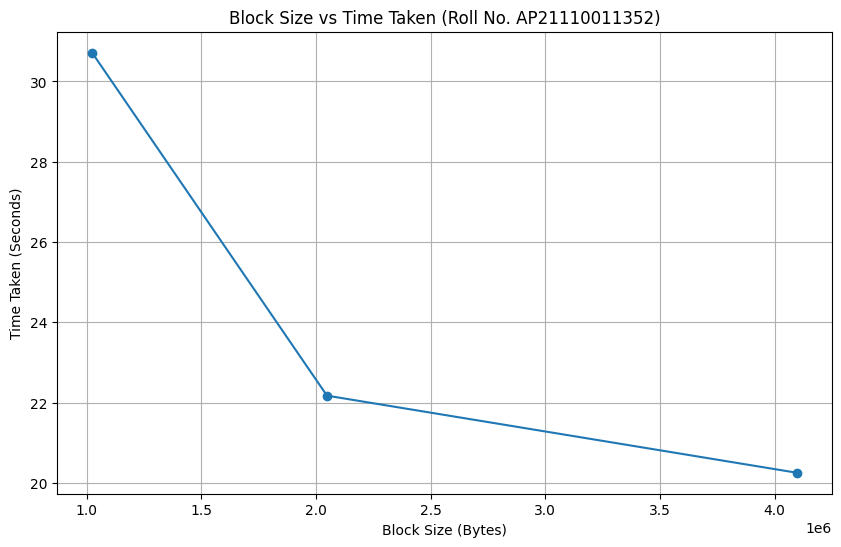

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(block_sizes, execution_times, marker='o')
plt.xlabel('Block Size (Bytes)')
plt.ylabel('Time Taken (Seconds)')
plt.title('Block Size vs Time Taken (Roll No. AP21110011352)')
plt.grid(True)
plt.show()


In [68]:
for b_size, time_taken in zip(block_sizes, execution_times):
    print(f"Block Size: {b_size} bytes - Time Taken: {time_taken:.2f} seconds")

Block Size: 1024000 bytes - Time Taken: 30.72 seconds
Block Size: 2048000 bytes - Time Taken: 22.17 seconds
Block Size: 4096000 bytes - Time Taken: 20.25 seconds
